In [ ]:
!pip install yfinance
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import matplotlib as mpl
from numpy.linalg import inv
from scipy.optimize import minimize

In [ ]:

# 무위험수익률, 수익률,공분산으로
# 샤프비율을 최대로 하는 접점포트폴리오 비중 계산 
def solveWeights(R, C, rf):
    
    # 파이썬은 함수안에 함수를 정의할 수 있다
    # 최적비중계산을 위해 다음과 같이 목적함수를 정의한다
    def obj(W, R, C, rf):
        mean = sum(R * W)
        var = np.dot(np.dot(W, C), W)
        #샤프비율을 효용함수로 한다
        util = (mean - rf) / np.sqrt(var) 
        # 효용함수 극대화= 효용함수 역함수를 최소화하는 것이다.
        return 1 / util  

    n = len(R)  # 투자자산 갯수

    # 동일비중으로 최적화 시작
    W = np.ones([n]) / n  
    # 비중범위는 0~100%사이(공매도나 차입조건이 없음)
    bnds = [(0., 1.) for i in range(n)]  
    # 제약조건은 비중합=100%
    cons = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.}) 
    # 최적화
    res = minimize(obj, W, (R, C, rf), method='SLSQP', constraints=cons, bounds=bnds)
    if not res.success:
      # 최적화 실패한 경우 
      raise BaseException(res.message)
    # 최적화 결과를 돌려준다  
    return res.x

In [ ]:
# 무위험수익률, 수익률,공분산으로 효율적 프런티어 계산
def solveFrontier(R, C, rf):

    # 파이썬은 함수안에 함수를 정의할 수 있다
    # 최적비중계산을 위해 다음과 같이 목적함수를 정의한다
    def obj(W, R, C, r):
        # 주어진 수익률에서 분산을 최소로 하는 비중 계산
        mean = sum(R * W)
        var = np.dot(np.dot(W, C), W)
        # 최적화 제약조건 페널티
        penalty = 100 * abs(mean - r)             
        return var + penalty

    # 효율적 프론티어를 구성하는 평균-분산을 돌려줄
    # 리스트를 미리 준비한다
    frontier_mean, frontier_var = [], []

    n = len(R)  # 투자자산 갯수

    # 수익률 최저~최대 사이를 반복한다
    for r in np.linspace(min(R), max(R), num=20):
        # 최적화 함수에 전달할 초기값으로 동일비중으로 시작한다
        W = np.ones([n]) / n 

        # 최적화 함수에 전달할 범위조건과 제약조건을 미리 준비한다
        # 범위조건: 각 구성자산의 투자비중은 0~100% 사이이며
        # 제약조건: 전체 투자비중은 100%이다.
        bnds = [(0, 1) for i in range(n)]
        cons = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})
        
        # 최적화 함수 minimize()은 최적화할 obj함수와 
        # 최적화를 시작할 초깃값을 인수로 받는다.         
        res = minimize(obj, W, (R, C, r), method='SLSQP', constraints=cons, bounds=bnds)
        if not res.success:
            # 최적화에 실패한 경우
            raise BaseException(res.message)
        
        # 효율적 프런티어 평균과 분산리스트에 
        # 최적포트폴리오 수익률과 분산 추가
        frontier_mean.append(r)
        frontier_var.append(np.dot(np.dot(res.x, C), res.x))
    return np.array(frontier_mean), np.array(frontier_var)

In [ ]:

# 효율적 포트폴리오 최적화        
def optimize_frontier(R, C, rf):

    # 접점포트폴리오 계산
    W = solveWeights(R, C, rf)
    # 투자비중으로 계산한 평균과 분산
    tan_mean = sum(R * W)
    tan_var = np.dot(np.dot(W, C), W)    

    # 효율적 포트폴리오 계산
    eff_mean, eff_var = solveFrontier(R, C, rf)

    # 비중, 접점포트폴리오의 평균/분산, 효율적 포트폴리오의 평균/분산을
    # 딕셔너리 데이터형으로 돌려준다    
    return {'weights':W, 'tan_mean':tan_mean, 'tan_var':tan_var, 'eff_mean':eff_mean, 'eff_var':eff_var}

In [ ]:
# 자산에 대한 투자자의 전망과 전망의 기대수익률을 행렬로 만든다
def CreateMatrixPQ(names, views):
    r, c = len(views), len(names)

    # 투자전망과 기대수익률 행렬
    # views[i][3]에는 기대수익률을 가리킴
    Q = [views[i][3] for i in range(r)]     

    # 전망행렬 P를 만들기 위해
    # 구성자산 딕셔너리 작성
    nameToIndex = dict()    
    for i, n in enumerate(names):
        nameToIndex[n] = i

    # 투자전망 
    P = np.zeros([r, c]) 
    for i, v in enumerate(views):
        # 가령 전망이 ('MSFT', '>', 'GE', 0.02) 이라면
        # views[i][0] <-- 'MSFT' --> name1
        # views[i][1] <-- '>'
        # views[i][2] <-- 'GE'   --> name2
        # views[i][3] <-- '0.02'
        name1, name2 = views[i][0], views[i][2]
        P[i, nameToIndex[name1]] = +1 if views[i][1] == '>' else -1
        P[i, nameToIndex[name2]] = -1 if views[i][1] == '>' else +1
    return np.array(Q), P

In [ ]:
tickers=['PFE','INTC','NFLX','JPM','XOM','GOOG','JNJ','AAPL','AMZN']
cap = {'PFE':201102000000,'INTC':257259000000,'NFLX':184922000000,
       'JPM':272178000000,'XOM':178228000000,'GOOG':866683000000,
       'JNJ':403335000000,'AAPL':1208000000000,'AMZN':1178000000000
      }
prices, caps = [], []

for s in tickers:    
    pxclose = yf.download(s, start='2018-01-01', end='2019-12-31')['Adj Close']
    prices.append(list(pxclose))  
    caps.append(cap[s])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
n = len(tickers)
W = np.array(caps) / sum(caps) # 시가총액의 비율계산
prices = np.matrix(prices)  # prices를 numpy matrix로 변환

# 수익률 행렬을 만들어 계산
rows, cols = prices.shape
returns = np.empty([rows, cols - 1])
for r in range(rows):
    for c in range(cols - 1):
        p0, p1 = prices[r, c], prices[r, c + 1]
        returns[r, c] = (p1 / p0) - 1

# 수익률계산
expreturns = np.array([])
for r in range(rows):
    expreturns = np.append(expreturns, np.mean(returns[r]))

# 공분산계산
covars = np.cov(returns)
R = (1 + expreturns) ** 250 - 1  # 연율화
C = covars * 250  # 연율화

# 무위험 이자율
rf = .015

In [ ]:

expreturns

array([ 0.00034886,  0.00076697,  0.00127909,  0.00068967, -0.00014778,
        0.00058903,  0.00026973,  0.00126127,  0.00106065])

In [ ]:
display(pd.DataFrame({'Return': R, 'Weight (based on market cap)': W}, index=tickers).T)

,PFE,INTC,NFLX,JPM,XOM,GOOG,JNJ,AAPL,AMZN
Return,0.091115,0.211269,0.376532,0.188103,-0.036273,0.158603,0.069750,0.370421,0.303458
Weight (based on market cap),0.042340,0.054163,0.038933,0.057304,0.037524,0.182471,0.084918,0.254331,0.248015


In [ ]:
display(pd.DataFrame(C, columns=tickers, index=tickers))

,PFE,INTC,NFLX,JPM,XOM,GOOG,JNJ,AAPL,AMZN
PFE,0.037416,0.021683,0.026074,0.015826,0.015789,0.018568,0.018293,0.019736,0.021604
INTC,0.021683,0.093592,0.054494,0.029861,0.027049,0.039894,0.017541,0.045418,0.042485
NFLX,0.026074,0.054494,0.165585,0.031794,0.027628,0.060322,0.020999,0.053177,0.081516
JPM,0.015826,0.029861,0.031794,0.041864,0.022214,0.028071,0.014437,0.027651,0.029184
XOM,0.015789,0.027049,0.027628,0.022214,0.040405,0.024244,0.014398,0.023460,0.022576
GOOG,0.018568,0.039894,0.060322,0.028071,0.024244,0.068207,0.016347,0.044920,0.054470
JNJ,0.018293,0.017541,0.020999,0.014437,0.014398,0.016347,0.037293,0.015893,0.016443
AAPL,0.019736,0.045418,0.053177,0.027651,0.023460,0.044920,0.015893,0.075312,0.051415
AMZN,0.021604,0.042485,0.081516,0.029184,0.022576,0.054470,0.016443,0.051415,0.090683


In [ ]:
opt1 = optimize_frontier(R, C, rf)

In [ ]:
# 포트폴리오 수익률 평균 및 분산
mean = sum(R * W)
var = np.dot(np.dot(W, C), W)

# 위험회피계수
lmbda = (mean - rf) / var  

# 균형초과수익률
pi = np.dot(np.dot(lmbda, C), W)

In [ ]:
opt2 = optimize_frontier(pi+rf, C, rf)

In [ ]:
views = [('XOM', '>', 'JPM', 0.02),('NFLX', '<', 'JNJ', 0.02)]
Q, P = CreateMatrixPQ(tickers, views)

# 위험조정상수
tau = .025  

# 투자자 전망의 불확실성 계산
# tau * P * C * transpose(P)
omega = np.dot(np.dot(np.dot(tau, P), C), np.transpose(P))

In [ ]:

print(Q,P)

[0.02 0.02] [[ 0.  0.  0. -1.  1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  1.  0.  0.]]


In [ ]:
# 투자자 전망과 합쳐진 균형초과수익률 계산
bl1 = inv(np.dot(tau, C))
bl2 = np.dot(np.dot(np.transpose(P), inv(omega)), P)
bl3 = np.dot(inv(np.dot(tau, C)), pi)
bl4 = np.dot(np.dot(np.transpose(P), inv(omega)), Q)
pi_adj = np.dot(inv(bl1 + bl2), (bl3 + bl4))

opt3 = optimize_frontier(pi_adj + rf, C, rf)

In [ ]:
from IPython.core.display import display, HTML
pd.options.display.float_format = '{:.2%}'.format

# 1번째 최적화 결과
display(HTML('<h2>Historical returns</h2>'))
display(pd.DataFrame({'Weight': opt1['weights']}, index=tickers).T)

# 2번째 최적화 결과
display(HTML('<h2>Implied returns</h2>'))
display(pd.DataFrame({'Weight': opt2['weights']}, index=tickers).T)

# 3번째 최적화 결과
display(HTML('<h2>Implied returns with adjusted views</h2>'))
display(pd.DataFrame({'Weight': opt3['weights']}, index=tickers).T)

,PFE,INTC,NFLX,JPM,XOM,GOOG,JNJ,AAPL,AMZN
Weight,0.00%,0.00%,13.58%,18.67%,0.00%,0.00%,0.00%,67.61%,0.14%


,PFE,INTC,NFLX,JPM,XOM,GOOG,JNJ,AAPL,AMZN
Weight,4.29%,5.40%,3.90%,5.75%,3.72%,18.26%,8.45%,25.43%,24.79%


,PFE,INTC,NFLX,JPM,XOM,GOOG,JNJ,AAPL,AMZN
Weight,3.24%,3.61%,0.00%,0.00%,11.73%,15.73%,21.83%,25.67%,18.19%


In [ ]:
def plotAssets(tickers, R, C, color='black'):
    # 포트폴리오 구성자산 출력
    plt.scatter([C[i, i] ** .5 for i in range(n)], R, marker='x', color=color)  
    for i in range(n): 
        plt.text(C[i, i] ** .5, R[i], '  %s' % tickers[i], verticalalignment='center', color=color) 

def plotFrontier(result, label=None, color='black'):
    # 최적화된 효율적 프런티어 출력
    plt.text(result['tan_var'] ** .5, result['tan_mean'], 'tangent', verticalalignment='center', color=color)
    plt.scatter(result['tan_var'] ** .5, result['tan_mean'], marker='o', color=color)
    plt.plot(result['eff_var'] ** .5, result['eff_mean'], label=label, color=color, linewidth=2, marker='D', markersize=9)

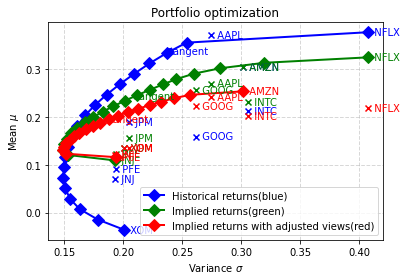

In [ ]:
# 1번째 최적화 결과를 차트로 출력
plotAssets(tickers, R, C, color='blue')
plotFrontier(opt1, label='Historical returns', color='blue')

# 2번째 최적화 결과를 차트로 출력
plotAssets(tickers, pi+rf, C, color='green')
plotFrontier(opt2, label='Implied returns', color='green')

# 3번째 최적화 결과를 차트로 출력
plotAssets(tickers, pi_adj+rf, C, color='red')
plotFrontier(opt3, label='Implied returns (adjusted views)', color='red')

# 차트에 공통된 속성을 지정한다(차트크기, 제목, 범례, 축이름 등)
plt.rcParams["figure.figsize"] = (12, 10)
plt.grid(alpha=0.3, color='gray', linestyle='--', linewidth=1)
plt.title('Portfolio optimization')
plt.legend(['Historical returns(blue)', 'Implied returns(green)','Implied returns with adjusted views(red)'])
plt.xlabel('Variance $\sigma$')
plt.ylabel('Mean $\mu$')
plt.show()